<a href="https://colab.research.google.com/github/Rahulsingh1939/-6Companies30days/blob/main/Analysis_of_Bainitic_Rail_Steel_using_a_Hybrid_ANN_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Bainitic Rail Steel using a Hybrid ANN-CNN model and Prediction for Yeild Strength


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [33]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
img_folder  = Path('/content/drive/MyDrive/Group A Project/train_images')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df = pd.read_csv('mdsi_data.csv')

df.fillna(df.mean(), inplace=True)
X_tabular = df.drop(columns=['YS (MPa)', 'UTS (MPa)', 'Elongation (%)'])  # Features
y = df['YS (MPa)']

In [25]:
scaler = MinMaxScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)

# Split data into train (70%), validation (20%), and test (10%)
train_idx, temp_idx = train_test_split(df.index, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.33, random_state=42)

X_tab_train = X_tabular_scaled[train_idx]
X_tab_val = X_tabular_scaled[val_idx]
X_tab_test = X_tabular_scaled[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

Sl. no. values for indices:
 [138, 66, 109, 182, 32, 13, 36, 29, 43, 83, 101, 146, 52, 121, 173, 77, 42, 151, 79, 127, 27, 143, 113, 125, 3, 78, 47, 160, 119, 91, 86, 144, 37, 205, 62, 23, 141, 114, 34, 12, 209, 181, 7, 28, 133, 206, 147, 5, 33, 116, 155, 123, 154, 115, 11, 63, 126, 156, 177, 1, 193, 163, 71, 166, 65, 45, 140, 41, 124, 24, 187, 157, 82, 40, 213, 48, 95, 164, 44, 148, 4, 106, 54, 134, 194, 169, 199, 50, 81, 35, 8, 111, 92, 84, 190, 195, 90, 9, 14, 60, 184, 132, 18, 167, 73, 208, 135, 178, 197, 64, 55, 108, 51, 175, 211, 170, 59, 49, 89, 22, 58, 161, 207, 188, 130, 38, 158, 202, 2, 53, 150, 131, 152, 104, 100, 117, 88, 203, 75, 122, 214, 21, 189, 72, 107, 15, 93, 180, 103]
Valid indices: [137  65 108  31  12  35  28  42  82 100 145  51 120 172  76  41  78 126
  26 142 112 124   2  77  46 118  90  85 143  36  61  22 140 113  33  11
   6  27 132 146   4  32 115 154 122 153 114  10  62 125   0 162  70  64
  44 139  40 123  23  81  39 212  47  94 163  43 147   3 105  53 133 

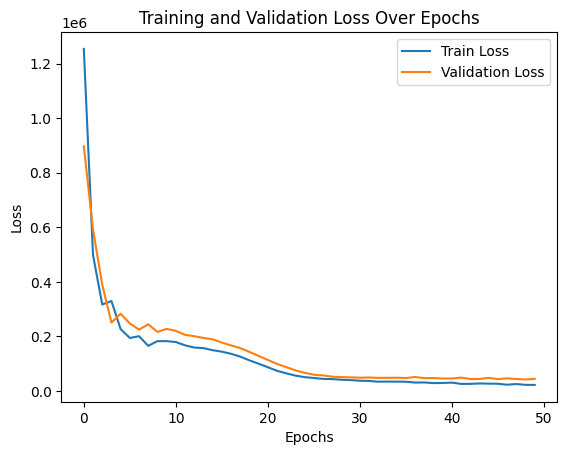

In [34]:

img_height, img_width = 224, 224

# Function to load and preprocess images
def load_images(df, indices, img_folder, id_column='Sl. no.'):
    images = []
    valid_indices = []
    # Check if id_column exists in the DataFrame
    if id_column not in df.columns:
        print(f"Warning: Column '{id_column}' not found in DataFrame. Using index as fallback.")
        # Use DataFrame index as fallback
        for idx in indices:
            img_path = os.path.join(img_folder, f"{idx+1}.jpg")  # Assuming 1-based indexing
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                valid_indices.append(idx)
            except FileNotFoundError:
                print(f"Warning: Image {img_path} not found. Skipping.")
                continue
    else:
        # Print id_column values for debugging
        print(f"{id_column} values for indices:\n", df.loc[indices, id_column].to_list())
        # Use the specified id_column
        for i, idx in enumerate(indices):
            id_value = df.loc[idx, id_column]
            img_path = os.path.join(img_folder, f"{id_value}.png")
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                valid_indices.append(idx)  # Store the DataFrame index
            except FileNotFoundError:
                print(f"Warning: Image {img_path} not found. Skipping.")
                continue
    # Convert valid_indices to an integer array
    valid_indices = np.array(valid_indices, dtype=np.int64)
    print(f"Valid indices: {valid_indices}")
    return np.array(images), valid_indices

X_img_train, train_valid_idx = load_images(df, train_idx, img_folder, id_column='Sl. no.')
X_img_val, val_valid_idx = load_images(df, val_idx, img_folder, id_column='Sl. no.')
X_img_test, test_valid_idx = load_images(df, test_idx, img_folder, id_column='Sl. no.')

# Filter tabular data and targets to match the valid image indices
X_tab_train = X_tabular_scaled[train_valid_idx]
y_train = y[train_valid_idx]
X_tab_val = X_tabular_scaled[val_valid_idx]
y_val = y[val_valid_idx]
X_tab_test = X_tabular_scaled[test_valid_idx]
y_test = y[test_valid_idx]

# Print shapes to verify alignment
print(f"X_tab_train shape: {X_tab_train.shape}")
print(f"X_img_train shape: {X_img_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_tab_val shape: {X_tab_val.shape}")
print(f"X_img_val shape: {X_img_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_tab_test shape: {X_tab_test.shape}")
print(f"X_img_test shape: {X_img_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Now drop 'Sl. no.' from X_tabular if it exists, as it's not needed for the ANN
if 'Sl. no.' in X_tabular.columns:
    X_tabular = X_tabular.drop(columns=['Sl. no.'])
    # Re-normalize after dropping the column
    scaler = MinMaxScaler()
    X_tabular_scaled = scaler.fit_transform(X_tabular)
    X_tab_train = X_tabular_scaled[train_valid_idx]
    X_tab_val = X_tabular_scaled[val_valid_idx]
    X_tab_test = X_tabular_scaled[test_valid_idx]

# --------------------------------------
# 3. Build the ANN for Tabular Data
# --------------------------------------
def build_ann(input_shape):
    # Ensure input_shape is a tuple
    if isinstance(input_shape, int):
        input_shape = (input_shape,)
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)  # Hidden layer 1
    x = Dense(64, activation='relu')(x)        # Hidden layer 2
    outputs = Dense(128, activation='linear')(x)  # Feature vector
    return Model(inputs, outputs)

# Create the ANN model
ann_model = build_ann(X_tab_train.shape[1])

# --------------------------------------
# 4. Build the CNN for Image Data
# --------------------------------------
def build_cnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)  # Conv layer 1
    x = MaxPooling2D((2, 2))(x)                        # Pooling layer 1
    x = Conv2D(64, (3, 3), activation='relu')(x)       # Conv layer 2
    x = MaxPooling2D((2, 2))(x)                        # Pooling layer 2
    x = Conv2D(128, (3, 3), activation='relu')(x)      # Conv layer 3
    x = MaxPooling2D((2, 2))(x)                        # Pooling layer 3
    x = Flatten()(x)                                   # Flatten the feature maps
    x = Dense(256, activation='relu')(x)               # Dense layer
    outputs = Dense(128, activation='linear')(x)       # Feature vector
    return Model(inputs, outputs)

# Create the CNN model
cnn_model = build_cnn((img_height, img_width, 3))

# --------------------------------------
# 5. Combine ANN and CNN Models
# --------------------------------------
# Define inputs for the hybrid model
tabular_input = Input(shape=(X_tab_train.shape[1],))
image_input = Input(shape=(img_height, img_width, 3))

# Extract feature vectors from ANN and CNN
ann_features = ann_model(tabular_input)
cnn_features = cnn_model(image_input)

# Concatenate the feature vectors
combined_features = Concatenate()([ann_features, cnn_features])

# Add regression head
x = Dense(64, activation='relu')(combined_features)  # Hidden layer
output = Dense(1, activation='linear')(x)            # Output layer (predicted YS)

# Create the final hybrid model
model = Model(inputs=[tabular_input, image_input], outputs=output)

# --------------------------------------
# 6. Compile and Train the Model
# --------------------------------------
# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    [X_tab_train, X_img_train], y_train,
    validation_data=([X_tab_val, X_img_val], y_val),
    epochs=50,
    batch_size=32
)

# --------------------------------------
# 7. Evaluate the Model
# --------------------------------------
# Predict on the test set
y_pred = model.predict([X_tab_test, X_img_test])

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R²): {r2:.2f}')

# --------------------------------------
# 8. Plot Training History (Optional)
# --------------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()